## Stage 3: CNN Classifier
The manual approach, yielded some positive results
Let's see if a machine learning algorithm using similar information might also work

**Plan:**

Chord Qualities:
1. Compute the summed frequency array, and note bin arrays
2. Put these into a CNN (try different combinations)
3. Try a few other models, including:
    - random forest
    - hmm
    - knn

Root Notes:
1. Given the calculated quality and frequency volume, try to work out what the root note is

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm
import tensorflow_io as tfio

TONE_A = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [3]:
def freq_to_rnote(freq):
    r = 12.0*np.log2(freq/TONE_A)
    return r

def rnote_to_freq(r):
    f = TONE_A*2**(r/12)
    return f

def get_note_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.2):
    """ rnote - name or number of note,fft_image - fourier image of signal,
    fft_freq - frequencies in fft_image,rnote_epsilon - halfwide of window to inspect
    return maximum volume(magnitude) of signal in freq window for rnote """
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    try:
        f0 = rnote_to_freq(rnote-rnote_epsilon)
        f1 = rnote_to_freq(rnote+rnote_epsilon)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except Exception:
        return 0.
    
    return maxVol

def get_notes_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.5,oct_range_from=-4.,oct_range_to=8.):
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    rnotes = np.arange(rnote+12.*oct_range_from,rnote+12.*oct_range_to,12.0)
    vol = []
    for rn in rnotes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    return np.max(vol)

def plot_notes(fileName):
    """convert the fft image from file to notes notations and plot on"""
    #print(fileName)
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.)) 
    fft_image = np.abs(fft.rfft(data,norm='forward')) 
    fft_freq = fft.rfftfreq(len(data),1./rate)
    vol_matrix = np.ndarray(shape=(12),dtype=np.float32)
    for rnote in range(12):
        vol_matrix[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
        
    plt.bar(NOTES, vol_matrix)
    plt.show()

In [6]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [183]:

# train_reshaped = train_set_note_volumes.reshape(train_set_note_volumes.shape[0], height, channels)
# test_reshaped = test_set_note_volumes.reshape(train_set_note_volumes.shape[0], height, channels)
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Convert string inputs to numerical labels
label_encoder = LabelEncoder()
train_set_encoded = label_encoder.fit_transform(train_set["Quality"])
test_set_encoded = label_encoder.transform(test_set["Quality"])

# show the classes in train_set["Quality"]
print(label_encoder.classes_)

# summarize the classes of train_set_encoded and test_set_encoded
# count the number of classes in train_set_encoded and test_set_encoded
print(train_set_encoded)
print(test_set_encoded)

print(len(np.unique(train_set_encoded)))
print(len(np.unique(test_set_encoded)))

# One-hot encode the numerical labels
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
train_set_one_hot = onehot_encoder.fit_transform(train_set_encoded.reshape(-1, 1))
test_set_one_hot = onehot_encoder.transform(test_set_encoded.reshape(-1, 1))

# Check the number of classes in train_set_one_hot and test_set_one_hot
print(train_set_one_hot[0])
print(test_set_one_hot[0])

# fit the model using train_set_note_volumes and train_set_one_hot, but exclude the File Path, Quality, and Root Note columns
model.fit(train_note_volumes.drop(columns=['Quality']), train_set_one_hot, epochs=3, batch_size=100)

# evaluate on test_set
model.evaluate(test_note_volumes, test_set_one_hot)


['aug' 'dim' 'maj' 'min']
[1 3 2 0 0 3 2 1 3 1 3 2 3 0 0 0 3 3 1 1 2 1 2 1 2 2 2 0 1 2 2 0 0 0 1 0 0
 1 1 0 2 0 0 1 2 3 0 3 1 0 0 1 1 1 2 1 2 0 3 3 3 0 2 1 1 1 2 0 2 2 1 2 0 0
 3 1 2 2 0 2 0 1 3 3 3 3 3 2 1 1 2 3 3 0 3 3 3 1 3 3 2 2 0 0 1 2 0 2 1 1 1
 2 2 2 3 3 3 3 2 3 0 1 1 0 3 2 1 3 0 2 3 0 2 2 0 0 0 0 3 1 2 2 1 1 2 2 1 2
 2 3 0 3 0 0 1 0 1 2 3 1 3 2 3 1 2 3 2 2 2 0 2 3 3 3 1 1 3 3 3 1 0 0 1 0 3
 1 3 0 0 3 1 1 0 0 1 1 0 0 0 2 0 0 2 3 1 3 3 3 3 0 2 1 3 3 3 1 2 0 3 0 3 1
 0 0 0 1 0 0 1 1 0 3 1 1 1 0 0 0 3 1 3 1 3 2 2 2 2 3 3 2 0 1 2 3 0 1 1 2 3
 0 0 1 2 2 1 3 3 0 3 2 3 2 1 1 0 1 1 2 0 3 0 3 2 0 0 0 0 1 0 2 2 2 1 2 3 1
 2 3 0 1 3 0 1 3 2 1 0 0 3 3 2 3 2 0 2 1 3 3 2 1 1 2 0 2 1 1 0 0 3 2 3 0 0
 3 0 1 0 3 2 2 2 1 0 0 0 3 2 0 3 0 3 0 3 3 0 0 3 1 2 3 2 0 2 1 2 0 1 0 0 3
 0 2 2 1 0 1 0 1 0 1 2 1 1 2 0 1 0 3 2 2 2 1 0 2 3 2 1 0 0 0 0 1 3 2 0 2 3
 3 3 2 1 2 2 3 1 1 1 0 2 3 1 0 2 1 3 2 3 1 3 2 1 1 3 3 1 2 2 3 0 0 3 3 3 2
 3 0 3 0 3 0 0 3 1 2 3 3 3 0 1 0 3 3 1 1 2 1 2 0 3 0 1 3 3 3 2 1 3 0 1 0 0

/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float32).

In [165]:
# normalise the data so that the volum
train_set_one_hot
len(train_set_one_hot)
train_note_volumes.head()

,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,Quality
0,0.00003,0.000025,0.000018,0.000055,0.000036,0.000027,0.000013,0.000015,0.000025,0.000013,0.000023,0.000039,dim
1,0.000044,0.000055,0.000015,0.000029,0.000035,0.000057,0.000049,0.000026,0.000057,0.000043,0.000023,0.000062,min
2,0.000499,0.000167,0.000135,0.007999,0.000137,0.00011,0.005141,0.000042,0.00003,0.000057,0.0023,0.002004,maj
3,0.000124,0.000125,0.002133,0.00356,0.000071,0.000068,0.002209,0.002292,0.000042,0.000077,0.002329,0.002155,aug
4,0.000223,0.000155,0.008392,0.000298,0.000249,0.000301,0.0052,0.000319,0.000039,0.000159,0.005519,0.000599,aug


In [167]:
# try running random forrests on the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(train_note_volumes.drop(columns=['Quality']), train_set_one_hot)
preds = rf.predict(test_note_volumes.drop(columns=['Quality']))
print(preds)
accuracy_score(test_set_one_hot, preds)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


0.18566775244299674

In [29]:
# try running a neural network on the data
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=12))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_set.drop(columns=['File Path', 'Quality', 'Root Note', 'Octave', 'Inversion']), train_set_one_hot, epochs=3, batch_size=100)

Epoch 1/3


/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:31: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.2162 - loss: 1.3865
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.2269 - loss: 1.3861
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2608 - loss: 1.3866 


In [178]:
# try running knn on the data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_note_volumes.drop(columns=['Quality']), train_note_volumes['Quality'])
preds = knn.predict(test_note_volumes.drop(columns=['Quality']))
accuracy_score(test_set['Quality'], preds)


0.0

In [177]:
# for every chord quality, set it to 0, 1, 2, 3
train_set['Quality'] = train_set['Quality'].replace(['maj', 'min', 'dim', 'aug'], [0, 1, 2, 3])
test_set['Quality'] = test_set['Quality'].replace(['maj', 'min', 'dim', 'aug'], [0, 1, 2, 3])

# try running xgboost on the data
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(train_note_volumes.drop(columns=['Quality']), train_set['Quality'])
preds = xgb.predict(test_note_volumes.drop(columns=['Quality']))
accuracy_score(test_set['Quality'], preds)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:A: object, A#: object, B: object, C: object, C#: object, D: object, D#: object, E: object, F: object, F#: object, G: object, G#: object

In [35]:
# try running a naive bayes classifier on the data
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(train_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']), train_set['Quality'])
preds = gnb.predict(test_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']))
accuracy_score(test_set['Quality'], preds)

0.19543973941368079

In [ ]:
accuracy = model.evaluate(test_reshaped, test_set_one_hot)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [36]:
# try running xgboost on the data
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(train_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']), train_set['Quality'])
preds = xgb.predict(test_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']))
accuracy_score(test_set['Quality'], preds)


0.50814332247557

In [37]:
# try linear regression on the data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score



lr = LinearRegression()
lr.fit(train_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']), train_set['Quality'])
preds = lr.predict(test_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']))
accuracy_score(test_set['Quality'], preds)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [19]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal

scheme = ["min", "maj", "dim", "aug"]

def load_wav_16k_mono(filename):
    sample_rate, wav_data = wav.read(filename)
    if wav_data.ndim > 1:
        wav_data = wav_data[:, 0]
    return wav_data, sample_rate

def preprocess(file_path, label):
    wav_data, sample_rate = load_wav_16k_mono(file_path)
    wav_data = wav_data[:48000]
    zero_padding = np.zeros(48000 - len(wav_data), dtype=np.float32)
    wav_data = np.concatenate([zero_padding, wav_data])
    spectrogram = np.abs(signal.stft(wav_data, nperseg=320, noverlap=288)[2])
    
    # Add an extra dimension to the spectrogram before resizing
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    # Ensure the spectrogram has the correct dimensions
    spectrogram = tf.image.resize(spectrogram, [300, 500])

    # crop the image

    # set the one-hot encoding of the label
    quality_one_hot = [0,0,0,0]
    for i in range(len(scheme)):
        if scheme[i] == label:
            quality_one_hot[i] = 1

    return spectrogram, quality_one_hot


In [20]:
spectrogram, label = preprocess(train_set['File Path'].iloc[1], train_set['Quality'].iloc[1])


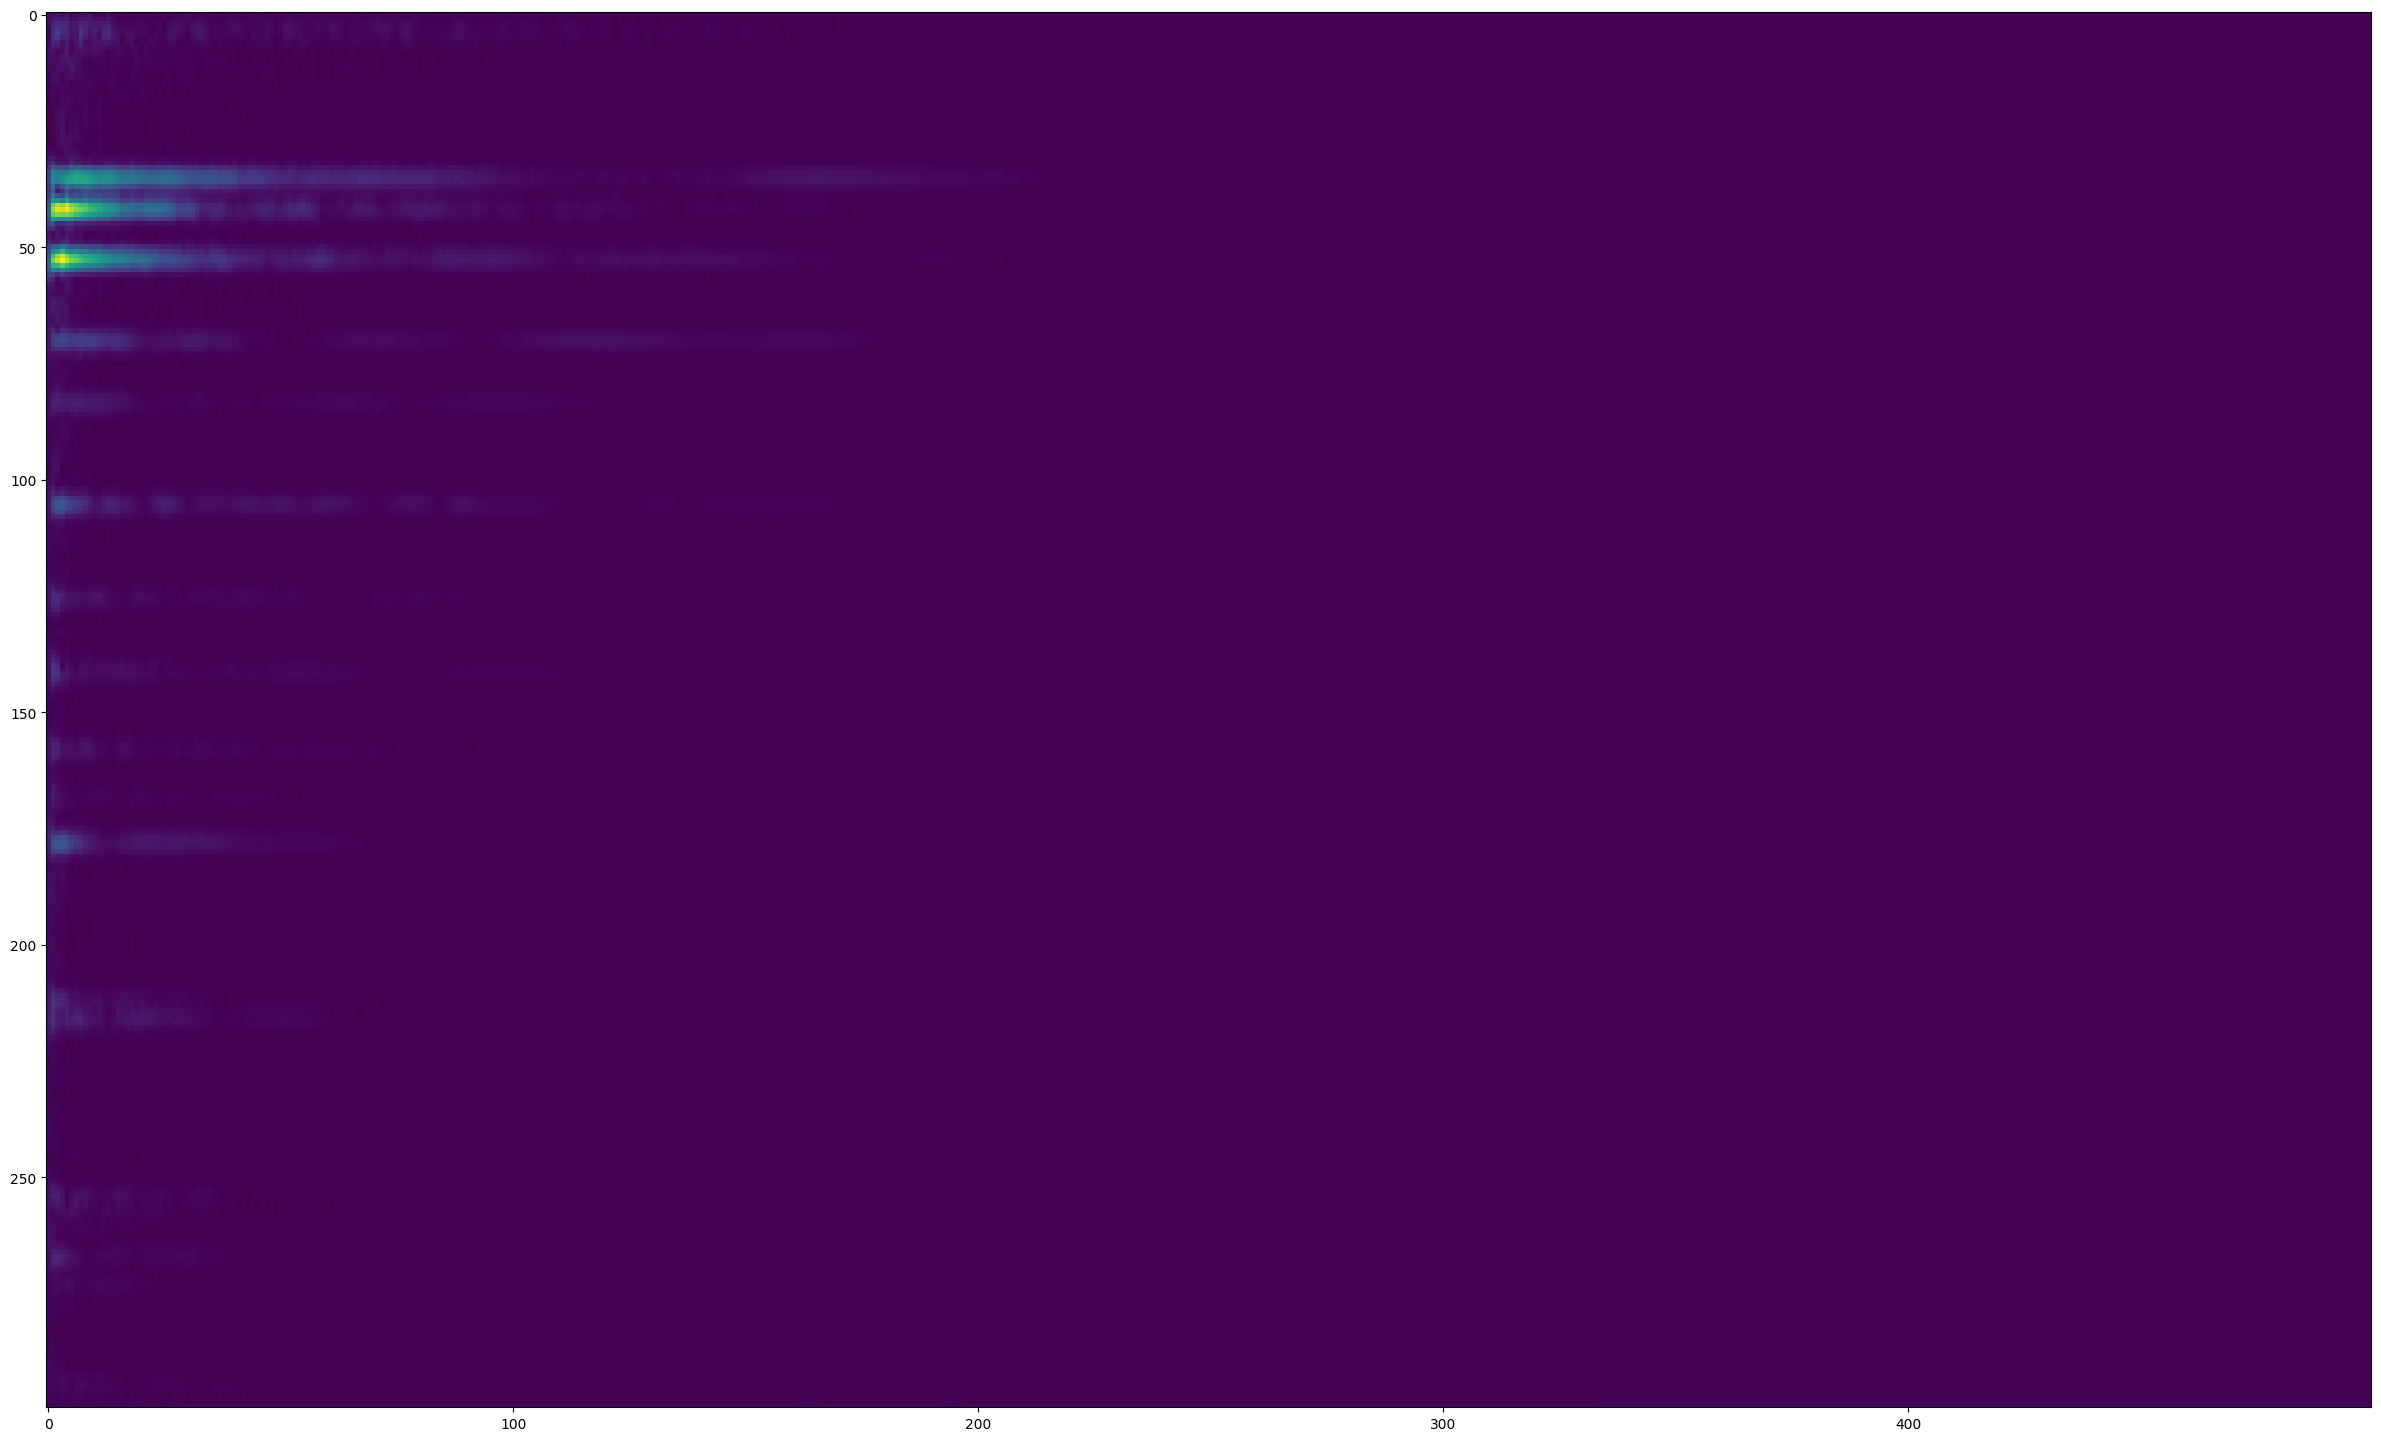

In [21]:
plt.figure(figsize=(30,20))
plt.imshow(spectrogram)
plt.show()

In [281]:
# get the dimensions of spectrogram
label

[1, 0, 0, 0]

In [312]:
# create a dataset made up of the train_set and test_set dataframes respectively, where each row is a spectrogram and the label is the chord quality
# this will be calculated using the preprocess function

import tensorflow as tf
import numpy as np

# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))

# Assuming your model is defined as 'model'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the dataset
model.fit(dataset, epochs=3)




# create a model that takes in the spectrogram and outputs the chord quality
# try a simple CNN model



Epoch 1/3


713/713 ━━━━━━━━━━━━━━━━━━━━ 54s 75ms/step - accuracy: 0.9939 - loss: 0.0517
Epoch 2/3
713/713 ━━━━━━━━━━━━━━━━━━━━ 54s 75ms/step - accuracy: 0.9684 - loss: 0.1675
Epoch 3/3
713/713 ━━━━━━━━━━━━━━━━━━━━ 52s 73ms/step - accuracy: 1.0000 - loss: 2.1892e-04


In [313]:
# test the model on the test_set

# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator
def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4605 - loss: 4.3380
Test loss: 4.65. Test accuracy: 41.37%


In [316]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from sklearn.model_selection import train_test_split

# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


In [324]:
# Assuming you have loaded your data into X_train, y_train, X_test, y_test
# Adjust the data loading according to your specific dataset.

# Split the data into training and validation sets
# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 161, 1501, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))

train_dataset = dataset.take(int(0.8 * 713))
val_dataset = dataset.skip(int(0.8 * 713))

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(161, 1501, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Dense(4, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with a validation set
history = model.fit(
    train_dataset,
    epochs=10, batch_size=32,
    validation_data=val_dataset
)

Epoch 1/10


/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


    570/Unknown 49s 85ms/step - accuracy: 0.2505 - loss: 30.9712

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.2505 - loss: 30.9304 - val_accuracy: 0.3077 - val_loss: 1.3623
Epoch 2/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.6145 - loss: 1.0665 - val_accuracy: 0.2867 - val_loss: 1.4229
Epoch 3/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.7452 - loss: 0.7385 - val_accuracy: 0.2308 - val_loss: 1.5510
Epoch 4/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 94ms/step - accuracy: 0.8257 - loss: 0.6415 - val_accuracy: 0.3147 - val_loss: 2.1933
Epoch 5/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.8264 - loss: 0.6185 - val_accuracy: 0.4196 - val_loss: 1.8858
Epoch 6/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 92ms/step - accuracy: 0.9622 - loss: 0.1869 - val_accuracy: 0.3986 - val_loss: 2.4392
Epoch 7/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.9681 - loss: 0.1307 - val_accuracy: 0.3776 - val_loss: 2.7320
Epoch 8/10
570/570 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.9903 - loss: 0.0356 - val_accura

In [27]:
# test the model on the test_set

# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator
def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 [==============================] - 3s 8ms/step - loss: 1.8028 - accuracy: 0.4137
Test loss: 1.80. Test accuracy: 41.37%


In [22]:
# replace all paths in train_set and test_set that have a # in it to replace the # with s
train_set['File Path'] = train_set['File Path'].str.replace('#', 's')
test_set['File Path'] = test_set['File Path'].str.replace('#', 's')

In [36]:
### 5-Fold Cross Validation ###
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, AvgPool2D

# Assuming train_set is your DataFrame
file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

# Use KFold for 10-fold cross-validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Loop over folds
# Loop over folds
for fold, (train_index, val_index) in enumerate(kf.split(file_paths, qualities)):
    print(f"Training Fold {fold + 1}")

    # Create training and validation datasets
    train_dataset = tf.data.Dataset.from_generator(
        generator, 
        output_signature=(
            tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )
    ).take(len(train_index))  # Use len(train_index) to take all elements in the training set

    val_dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32)
        )
    ).take(len(val_index))  # Use len(val_index) to take all elements in the validation set

    # Build and compile your model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 500, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(pool_size=(2, 1), strides=None, padding='valid', data_format=None))
    model.add(Dropout(0.5))  # Adjust the dropout rate as needed

    # add a pool-max layer
    model.add(MaxPooling2D(pool_size=(2, 1), strides=None, padding='valid', data_format=None))


    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 1), strides=None, data_format=None))
    model.add(Dropout(0.5))  # Adjust the dropout rate as needed

    model.add(MaxPooling2D(pool_size=(2, 1), strides=None, data_format=None))
    model.add(Dropout(0.5))  # Adjust the dropout rate as needed
    model.add(Conv2D(128, (12, 9), activation='relu'))
    model.add(Dropout(0.5))  # Adjust the dropout rate as needed

    model.add(Conv2D(25, (1, 1), activation='linear'))
    model.add(AvgPool2D(pool_size=(6, 3), strides=None, padding='valid', data_format=None))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))


    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model on the current fold
    model.fit(train_dataset, epochs=5, batch_size=32, validation_data=val_dataset)

    # Evaluate the model on the test set or perform any other necessary actions
    test_loss, test_accuracy = model.evaluate(val_dataset)
    print(f"Fold {fold + 1} - Test Accuracy: {test_accuracy}")


# You can use the trained model for predictions or other tasks after the loop

# test the model on the test_set



Training Fold 1
Epoch 1/5
594/594 [==============================] - 139s 234ms/step - loss: 1.4350 - accuracy: 0.2256 - val_loss: 1.3894 - val_accuracy: 0.2353
Epoch 2/5
594/594 [==============================] - 140s 236ms/step - loss: 1.3924 - accuracy: 0.2407 - val_loss: 1.3879 - val_accuracy: 0.2353
Epoch 3/5
594/594 [==============================] - 138s 232ms/step - loss: 1.3911 - accuracy: 0.2593 - val_loss: 1.3881 - val_accuracy: 0.2353
Epoch 4/5
594/594 [==============================] - 139s 234ms/step - loss: 1.3911 - accuracy: 0.2542 - val_loss: 1.3883 - val_accuracy: 0.2353
Epoch 5/5
119/119 [==============================] - 7s 55ms/step - loss: 1.3935 - accuracy: 0.2353
Fold 1 - Test Accuracy: 0.23529411852359772
Training Fold 2
Epoch 1/5
594/594 [==============================] - 143s 241ms/step - loss: 1.4430 - accuracy: 0.2290 - val_loss: 1.3879 - val_accuracy: 0.2353
Epoch 2/5
594/594 [==============================] - 142s 238ms/step - loss: 1.3913 - accuracy: 0.2

In [30]:
# select model with best accuracy and save it
# save the model
model.save('model.h5')

# load the model
from keras.models import load_model
model = load_model('model.h5')

# test the model on the test_set

# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator

def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


307/307 [==============================] - 3s 9ms/step - loss: 1.3891 - accuracy: 0.2476
Test loss: 1.39. Test accuracy: 24.76%


In [31]:
# Assuming you have loaded your data into X_train, y_train, X_test, y_test
# Adjust the data loading according to your specific dataset.

# Split the data into training and validation sets
# Assuming train_set is your DataFrame
import PoolMax2D from keras.layers


file_paths = train_set['File Path'].to_numpy()
qualities = train_set['Quality'].to_numpy()

# Create a dataset using from_generator
def generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)


        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))

train_dataset = dataset.take(int(0.8 * 713))
val_dataset = dataset.skip(int(0.8 * 713))

model = Sequential()
# add a convolutional layer, recti
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 500, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='valid'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='valid')))
model.add(PoolMax2D(pool_size=(2, 1), strides=None, padding='valid', data_format=None))
model.add(Dropout(0.5))  # Adjust the dropout rate as needed

# add a pool-max layer
model.add(PoolMax2D(pool_size=(2, 1), strides=None, padding='valid', data_format=None))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1), strides=None, data_format=None))
model.add(Dropout(0.5))  # Adjust the dropout rate as needed

model.add(MaxPooling2D(pool_size=(2, 1), strides=None, data_format=None))
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Conv2D(128, (12, 9), activation='relu'))

model.add(Conv2D(25, (1, 1), activation='linear'))
model.add(AvgPool2D(pool_size=(13, 3), strides=None, padding='valid', data_format=None))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with a validation set
history = model.fit(
    train_dataset,
    epochs=10, batch_size=32,
    validation_data=val_dataset
)

Epoch 1/10
570/570 [==============================] - 23s 41ms/step - loss: 8.0655 - accuracy: 0.2509 - val_loss: 1.3835 - val_accuracy: 0.2657
Epoch 2/10
570/570 [==============================] - 27s 48ms/step - loss: 1.2485 - accuracy: 0.4754 - val_loss: 1.3855 - val_accuracy: 0.2308
Epoch 3/10
570/570 [==============================] - 28s 49ms/step - loss: 1.0501 - accuracy: 0.6193 - val_loss: 1.4243 - val_accuracy: 0.2937
Epoch 4/10
570/570 [==============================] - 24s 42ms/step - loss: 0.7792 - accuracy: 0.7386 - val_loss: 2.0487 - val_accuracy: 0.3497
Epoch 5/10
570/570 [==============================] - 23s 40ms/step - loss: 0.4291 - accuracy: 0.8737 - val_loss: 2.1408 - val_accuracy: 0.3147
Epoch 6/10
570/570 [==============================] - 23s 41ms/step - loss: 0.2018 - accuracy: 0.9579 - val_loss: 1.5796 - val_accuracy: 0.3706
Epoch 7/10
570/570 [==============================] - 23s 40ms/step - loss: 0.1123 - accuracy: 0.9719 - val_loss: 1.4408 - val_accuracy:

In [32]:
# Assuming train_set is your DataFrame
file_paths = test_set['File Path'].to_numpy()
qualities = test_set['Quality'].to_numpy()

# Create a dataset using from_generator

def test_generator():
    for file_path, quality in zip(file_paths, qualities):
        spectrogram, quality_one_hot = preprocess(file_path, quality)
        spectrogram = tf.expand_dims(spectrogram, axis=0)
        quality_one_hot = tf.expand_dims(quality_one_hot, axis=0)

        yield spectrogram, tf.convert_to_tensor(np.array(quality_one_hot), dtype=tf.float32)

test_dataset = tf.data.Dataset.from_generator(test_generator, output_signature=(
    tf.TensorSpec(shape=(None, 300, 500, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(None,4), dtype=tf.float32)
))


test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

307/307 [==============================] - 3s 8ms/step - loss: 2.0562 - accuracy: 0.4463
Test loss: 2.06. Test accuracy: 44.63%
